In [12]:
import pandas as pd
import numpy as np
import sys
import math
import seaborn as sns
from matplotlib import pyplot as plt
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, cell_type_distribution
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score

In [ ]:
# if save session
import dill
dill.dump_session('cytof_notebook_env.db')

In [ ]:
# restore session
import dill
dill.load_session('cytof_notebook_env.db')

In [15]:
output_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\output_data\\Tribus_benchmarking\\"

## Run Tribus on TNBC

cols = ['Vimentin', 'SMA','FoxP3', 'Lag3', 'CD4', 
        'CD16', 'CD56', 'PD1', 'CD31','PD-L1', 
        'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 
        'CD163','CD68', 'CD8', 'CD3', 'IDO', 
        'Keratin17', 'CD63','CD45RO', 'CD20', 'p53', 
        'Beta catenin', 'HLA-DR', 'CD11b', 'CD45','H3K9ac', 
        'Pan-Keratin', 'H3K27me3', 'MPO','Keratin6', 'HLA_Class_1', 
        'dsDNA']

In [5]:
# read input files
# no outlier filtering
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data_origin.csv")
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\logic_gate_save_v1.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)

<Axes: >

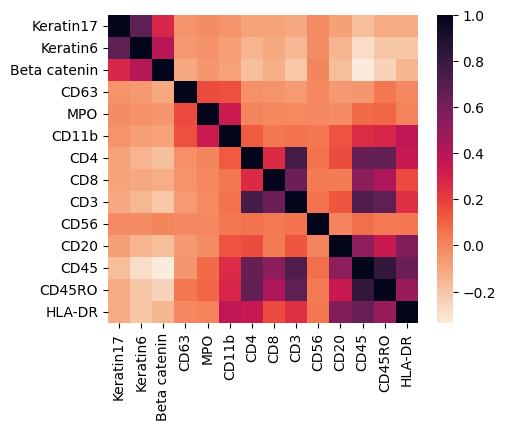

In [3]:
# check the marker correlation matrix we choose for the clustering method
marker_df = sample_data[logic["Global"].index]
plt.figure(figsize=(5,4))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

In [5]:
all_cols = ['Vimentin', 'SMA','FoxP3', 'Lag3', 'CD4', 
        'CD16', 'CD56', 'PD1', 'CD31','PD-L1', 
        'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 
        'CD163','CD68', 'CD8', 'CD3', 'IDO', 
        'Keratin17', 'CD63','CD45RO', 'CD20', 'p53', 
        'Beta catenin', 'HLA-DR', 'CD11b', 'CD45','H3K9ac', 
        'Pan-Keratin', 'H3K27me3', 'MPO','Keratin6', 'HLA_Class_1', 
        'dsDNA']

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(sample_data[all_cols], 40))

Top Absolute Correlations
CD45RO        CD45           0.820844
CD4           CD3            0.759777
H3K9ac        H3K27me3       0.738077
CD3           CD45           0.725486
Keratin17     Keratin6       0.675468
CD3           CD45RO         0.675216
CD4           CD45RO         0.665267
              CD45           0.647985
HLA-DR        CD45           0.637291
CD8           CD3            0.634147
CD20          HLA-DR         0.562540
CD45          HLA_Class_1    0.554033
CD8           CD45           0.526720
CD20          CD45           0.521038
Pan-Keratin   Keratin6       0.517714
CD45RO        HLA-DR         0.491341
HLA-DR        HLA_Class_1    0.488612
CD45RO        HLA_Class_1    0.476731
H3K27me3      dsDNA          0.473892
CD11c         HLA-DR         0.462931
              CD45           0.454886
Beta catenin  Pan-Keratin    0.454825
H3K9ac        dsDNA          0.446016
CD16          CD68           0.427049
CD8           CD45RO         0.426251
CD11c         CD45RO    

Global, subsetting done
Myeloid, subsetting done
6.221587884426117 minutes


<Axes: xlabel='Cell_type'>

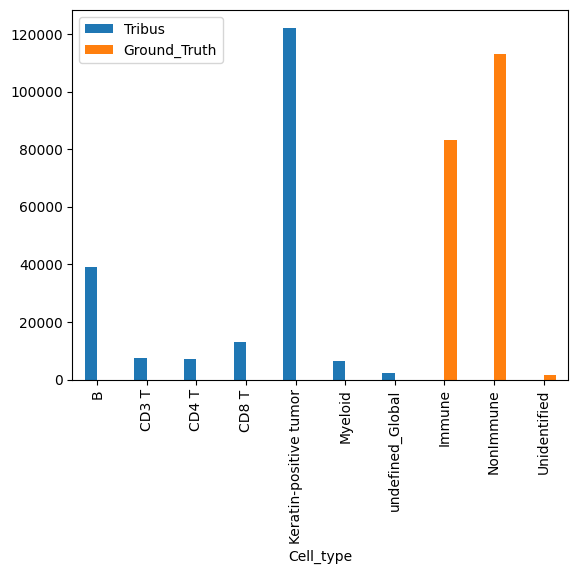

<Figure size 2000x600 with 0 Axes>

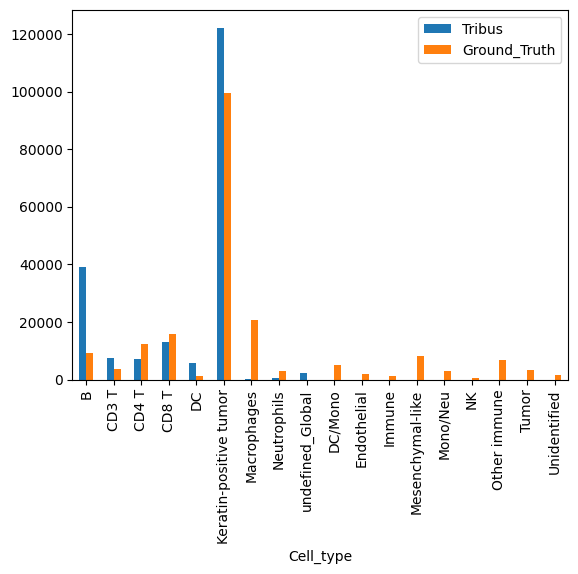

In [6]:
# Run Tribus on z-scored dataset

# Improve the result by checking the method part in paper: Cells with low expression across all markers used for clustering (sum < 0.1) were removed prior to clustering..
# Logic table need to be changed.
# MAX_PERCENTILE = 99
# REQUIRED_CELLS_FOR_CLUSTERING = 5000
# THRESHOLD_LOW = 0.001

depth = 2
labels, scores = run_tribus(sample_data, logic, depth=depth, normalization=z_score, 
                            clustering_threshold=5000, undefined_threshold=0.001, other_threshold=0.1, random_state=43) # modify depth

# cell_type_distribution(labels, level="Global")
Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["Global"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["upperGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["final_label"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["DetailedGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

plt.figure(figsize=(20,6))
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

## Clustering quality check

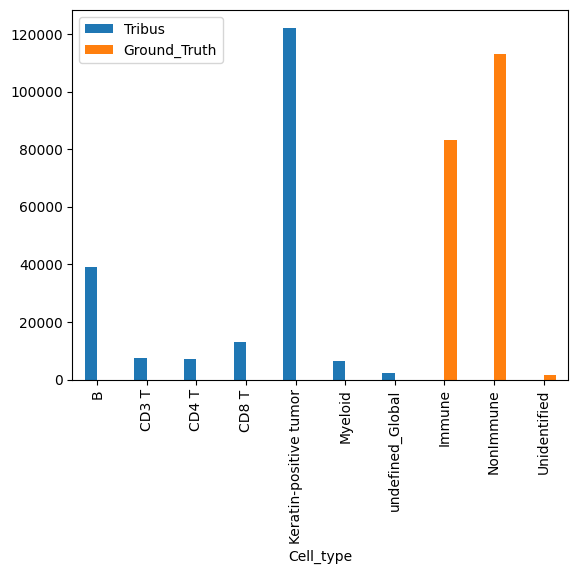

<Figure size 2000x600 with 0 Axes>

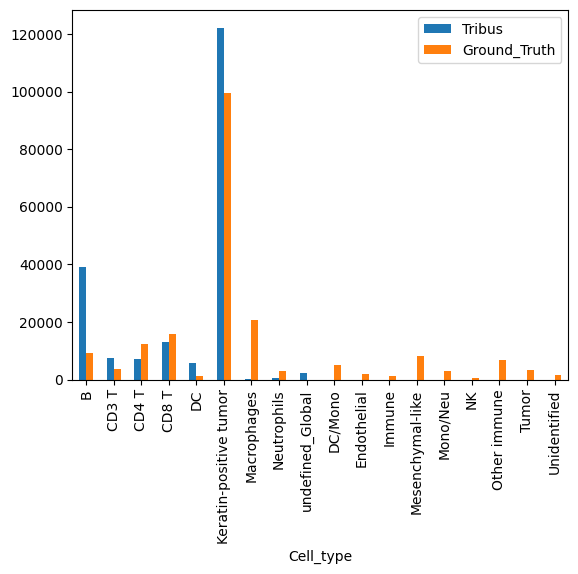

In [17]:
# cell_type_distribution(labels, level="Global")
Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["Global"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["upperGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["final_label"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["DetailedGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

plt.figure(figsize=(20,6))
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

plt.savefig("{}Cytof_num_level2.svg".format(output_path))
plt.show()

In [ ]:
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=True, fname="{}Cytof_heatmap_{}.svg".format(output_path,i),
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)

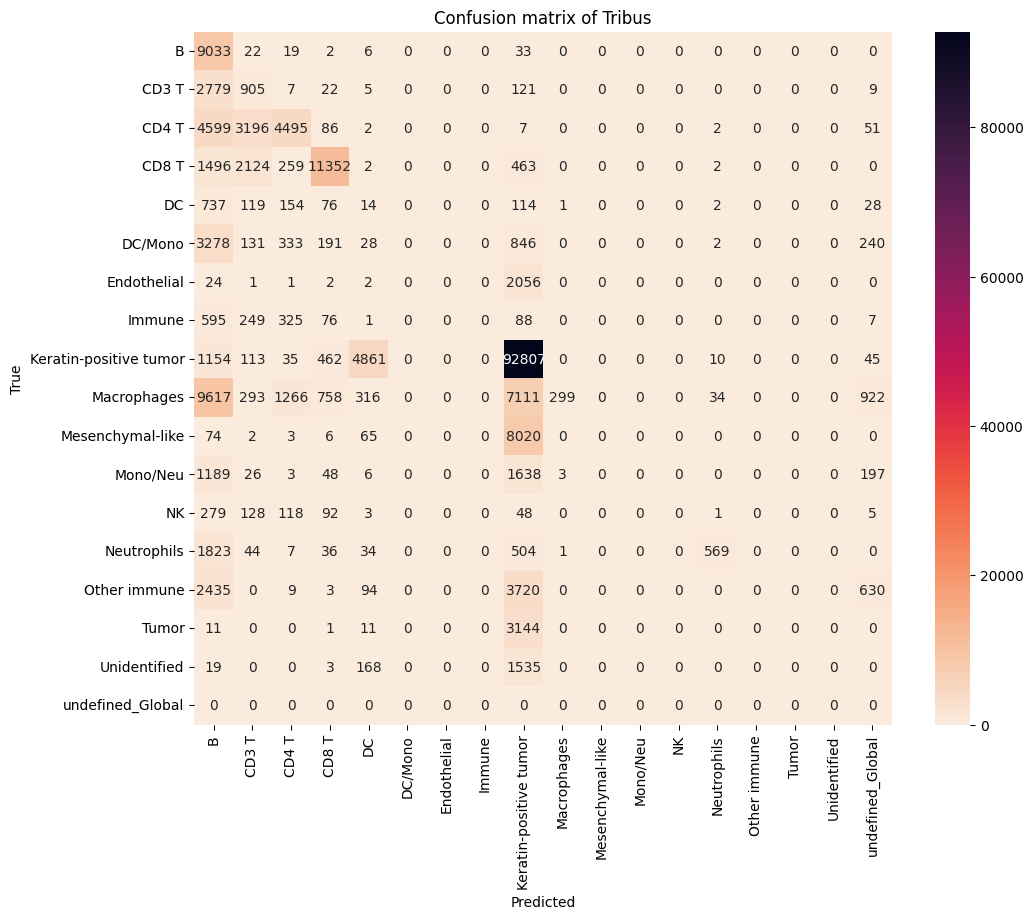

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_20492\517337728.py:49: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


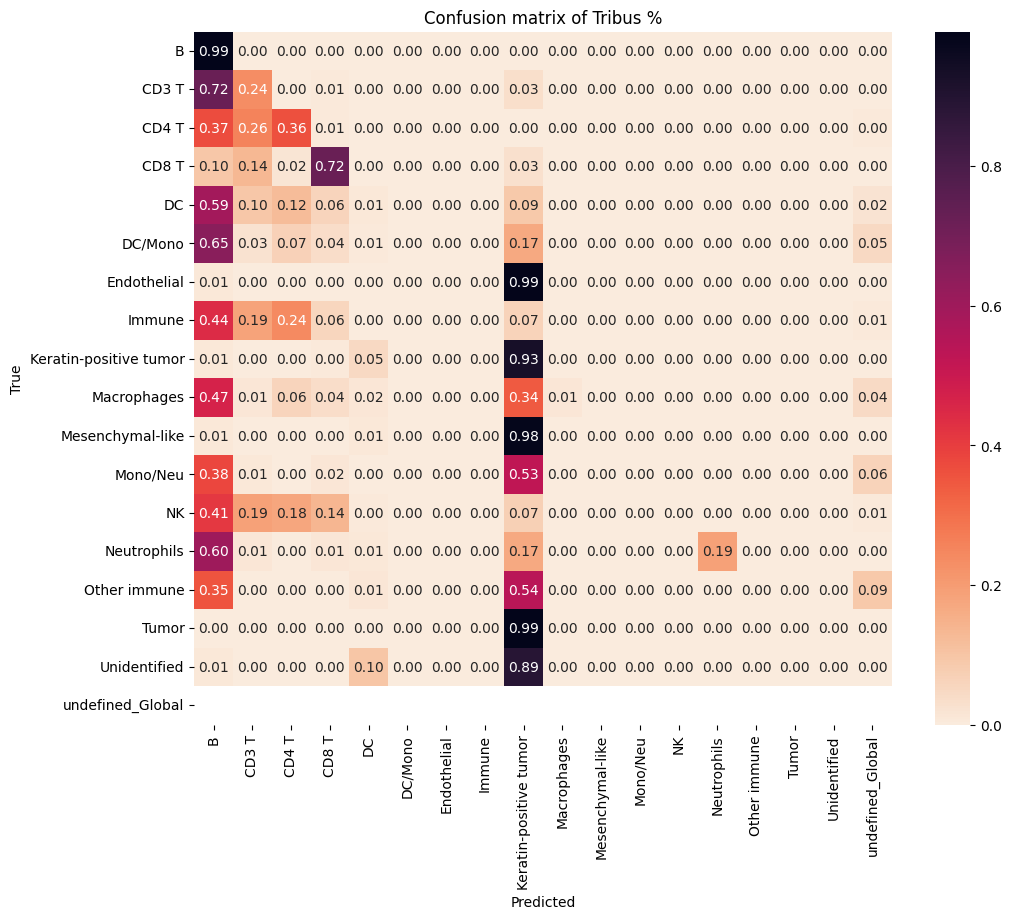

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.7587815809065522, Accuracy score = 0.6043869322838151, Precision score = 0.6200664628160311, F1 score = 0.540873773538367


In [19]:
# confusion matrix
if depth == 1: 
    celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
    # cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm_labels = np.union1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
else:
    celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
        # cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm_labels = np.union1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.625, len(np.unique(cm_labels))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')

RI = rand_score(celltype_true, celltype_pred) #between 0-1
AS = accuracy_score(celltype_true, celltype_pred)
PS = precision_score(celltype_true, celltype_pred, average='weighted')
F1 = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))

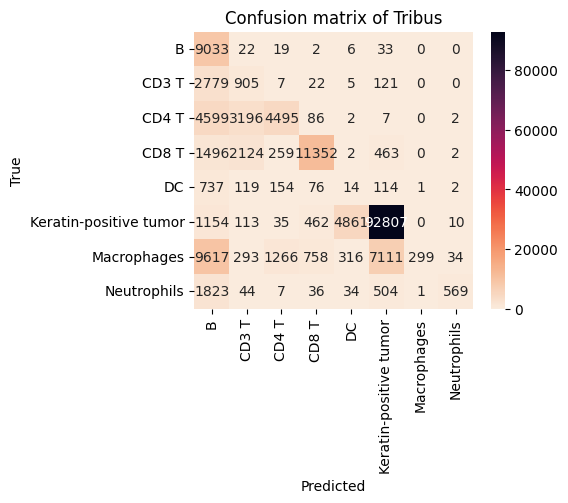

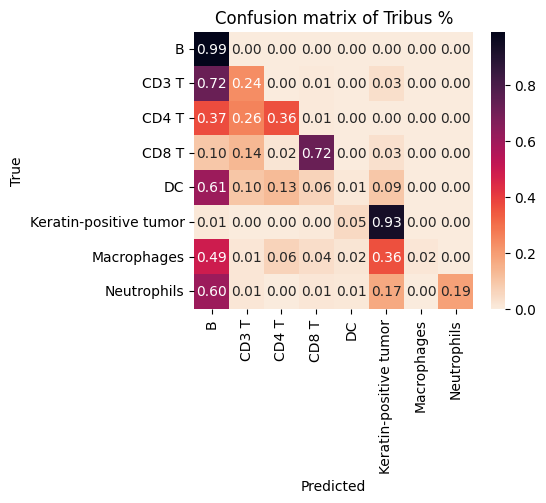

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.7587815809065522, Accuracy score = 0.6043869322838151, Precision score = 0.6200664628160311, F1 score = 0.540873773538367


In [20]:
# confusion matrix
if depth == 1: 
    celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
    cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
else:
    celltype_true = np.array(sample_data["DetailedGroup"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
    cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig("{}Cytof_cm_level_2.svg".format(output_path))
    plt.show()

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig("{}Cytof_cmn_level_2.svg".format(output_path))
    plt.show()

RI = rand_score(celltype_true, celltype_pred) #between 0-1
AS = accuracy_score(celltype_true, celltype_pred)
PS = precision_score(celltype_true, celltype_pred, average='weighted')
F1 = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.7587815809065522, Accuracy score = 0.6043869322838151, Precision score = 0.6200664628160311, F1 score = 0.540873773538367


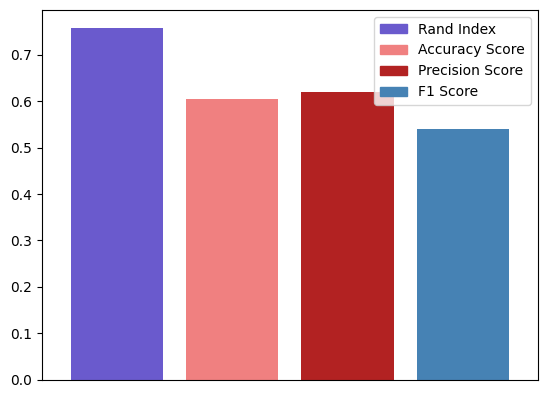

In [21]:
# Calculate average accuracy metrics and visualization with barplot

RI_avg = rand_score(celltype_true, celltype_pred) #between 0-1
AS_avg = accuracy_score(celltype_true, celltype_pred)
PS_avg = precision_score(celltype_true, celltype_pred, average='weighted')
F1_avg = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], 
                  index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])
df.to_csv("{}Cytof_benchmarking_stats_report_all.csv".format(output_path))

colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
df.plot.bar(y='Value', width = 0.8, legend=False, 
            color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

plt.savefig("{}Cytof_metrics_average.svg".format(output_path))
plt.show()

                            TN     FP     FN     TP  accuracy
B                       158454  30109     82   9033  0.847272
CD3 T                   187382   6448   2943    905  0.952493
CD4 T                   182701   2539   7943   4495  0.946974
CD8 T                   180116   1864   4346  11352  0.968585
DC                      190829   5604   1231     14  0.965424
Keratin-positive tumor   68743  29448   6680  92807  0.817238
Macrophages             177057      5  20317    299  0.897196
Neutrophils             194607     53   2449    569  0.987343
                        precision    recall  f1-score   support
B                        0.230775  0.991004  0.374371    9115.0
CD3 T                    0.123079  0.235187  0.161593    3848.0
CD4 T                    0.639039  0.361393  0.461689   12438.0
CD8 T                    0.858959  0.723149  0.785225   15698.0
DC                       0.002492  0.011245  0.004080    1245.0
Keratin-positive tumor   0.759126  0.932856  0.837072   99

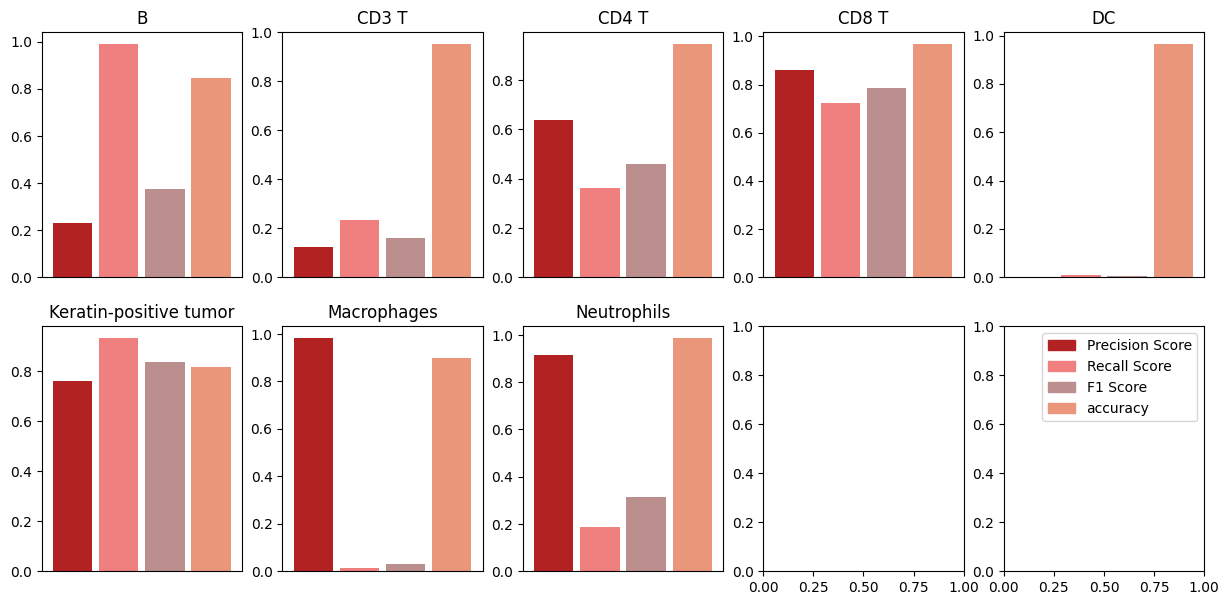

In [22]:
# accuracy metrics per cell type

classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))

stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
stats_df = pd.DataFrame()
for i in range(len(stats_array)):
    stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
stats_df.columns = ["TN", "FP", "FN", "TP"]
stats_df.index = [classes]
stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
print(stats_df)
stats_df.to_csv("{}Cytof_benchmarking_stats.csv".format(output_path))

report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv("{}Cytof_benchmarking_stats_report.csv".format(output_path))
# Support is the number of actual occurrences of the class in the specified dataset.

rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 5)
fig, ax = plt.subplots(rows, 5, figsize=(15,7))

for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
    
    celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
    df = report_df.loc[celltype]
    df["accuracy"] = stats_df.iloc[i,-1].tolist()
    df = df[["precision", "recall", "f1-score", "accuracy"]]
    
    colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
    df.plot.bar(y='Value', ax=ax[int(i / 5)][i % 5], width = 0.85, 
                title="{}".format(celltype), legend=False, 
                color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

plt.savefig("{}Cytof_metrics_per_celltype.svg".format(output_path))
plt.show()


In [ ]:
labels.to_csv("{}Cytof_cl_benchmarking.csv".format(output_path))

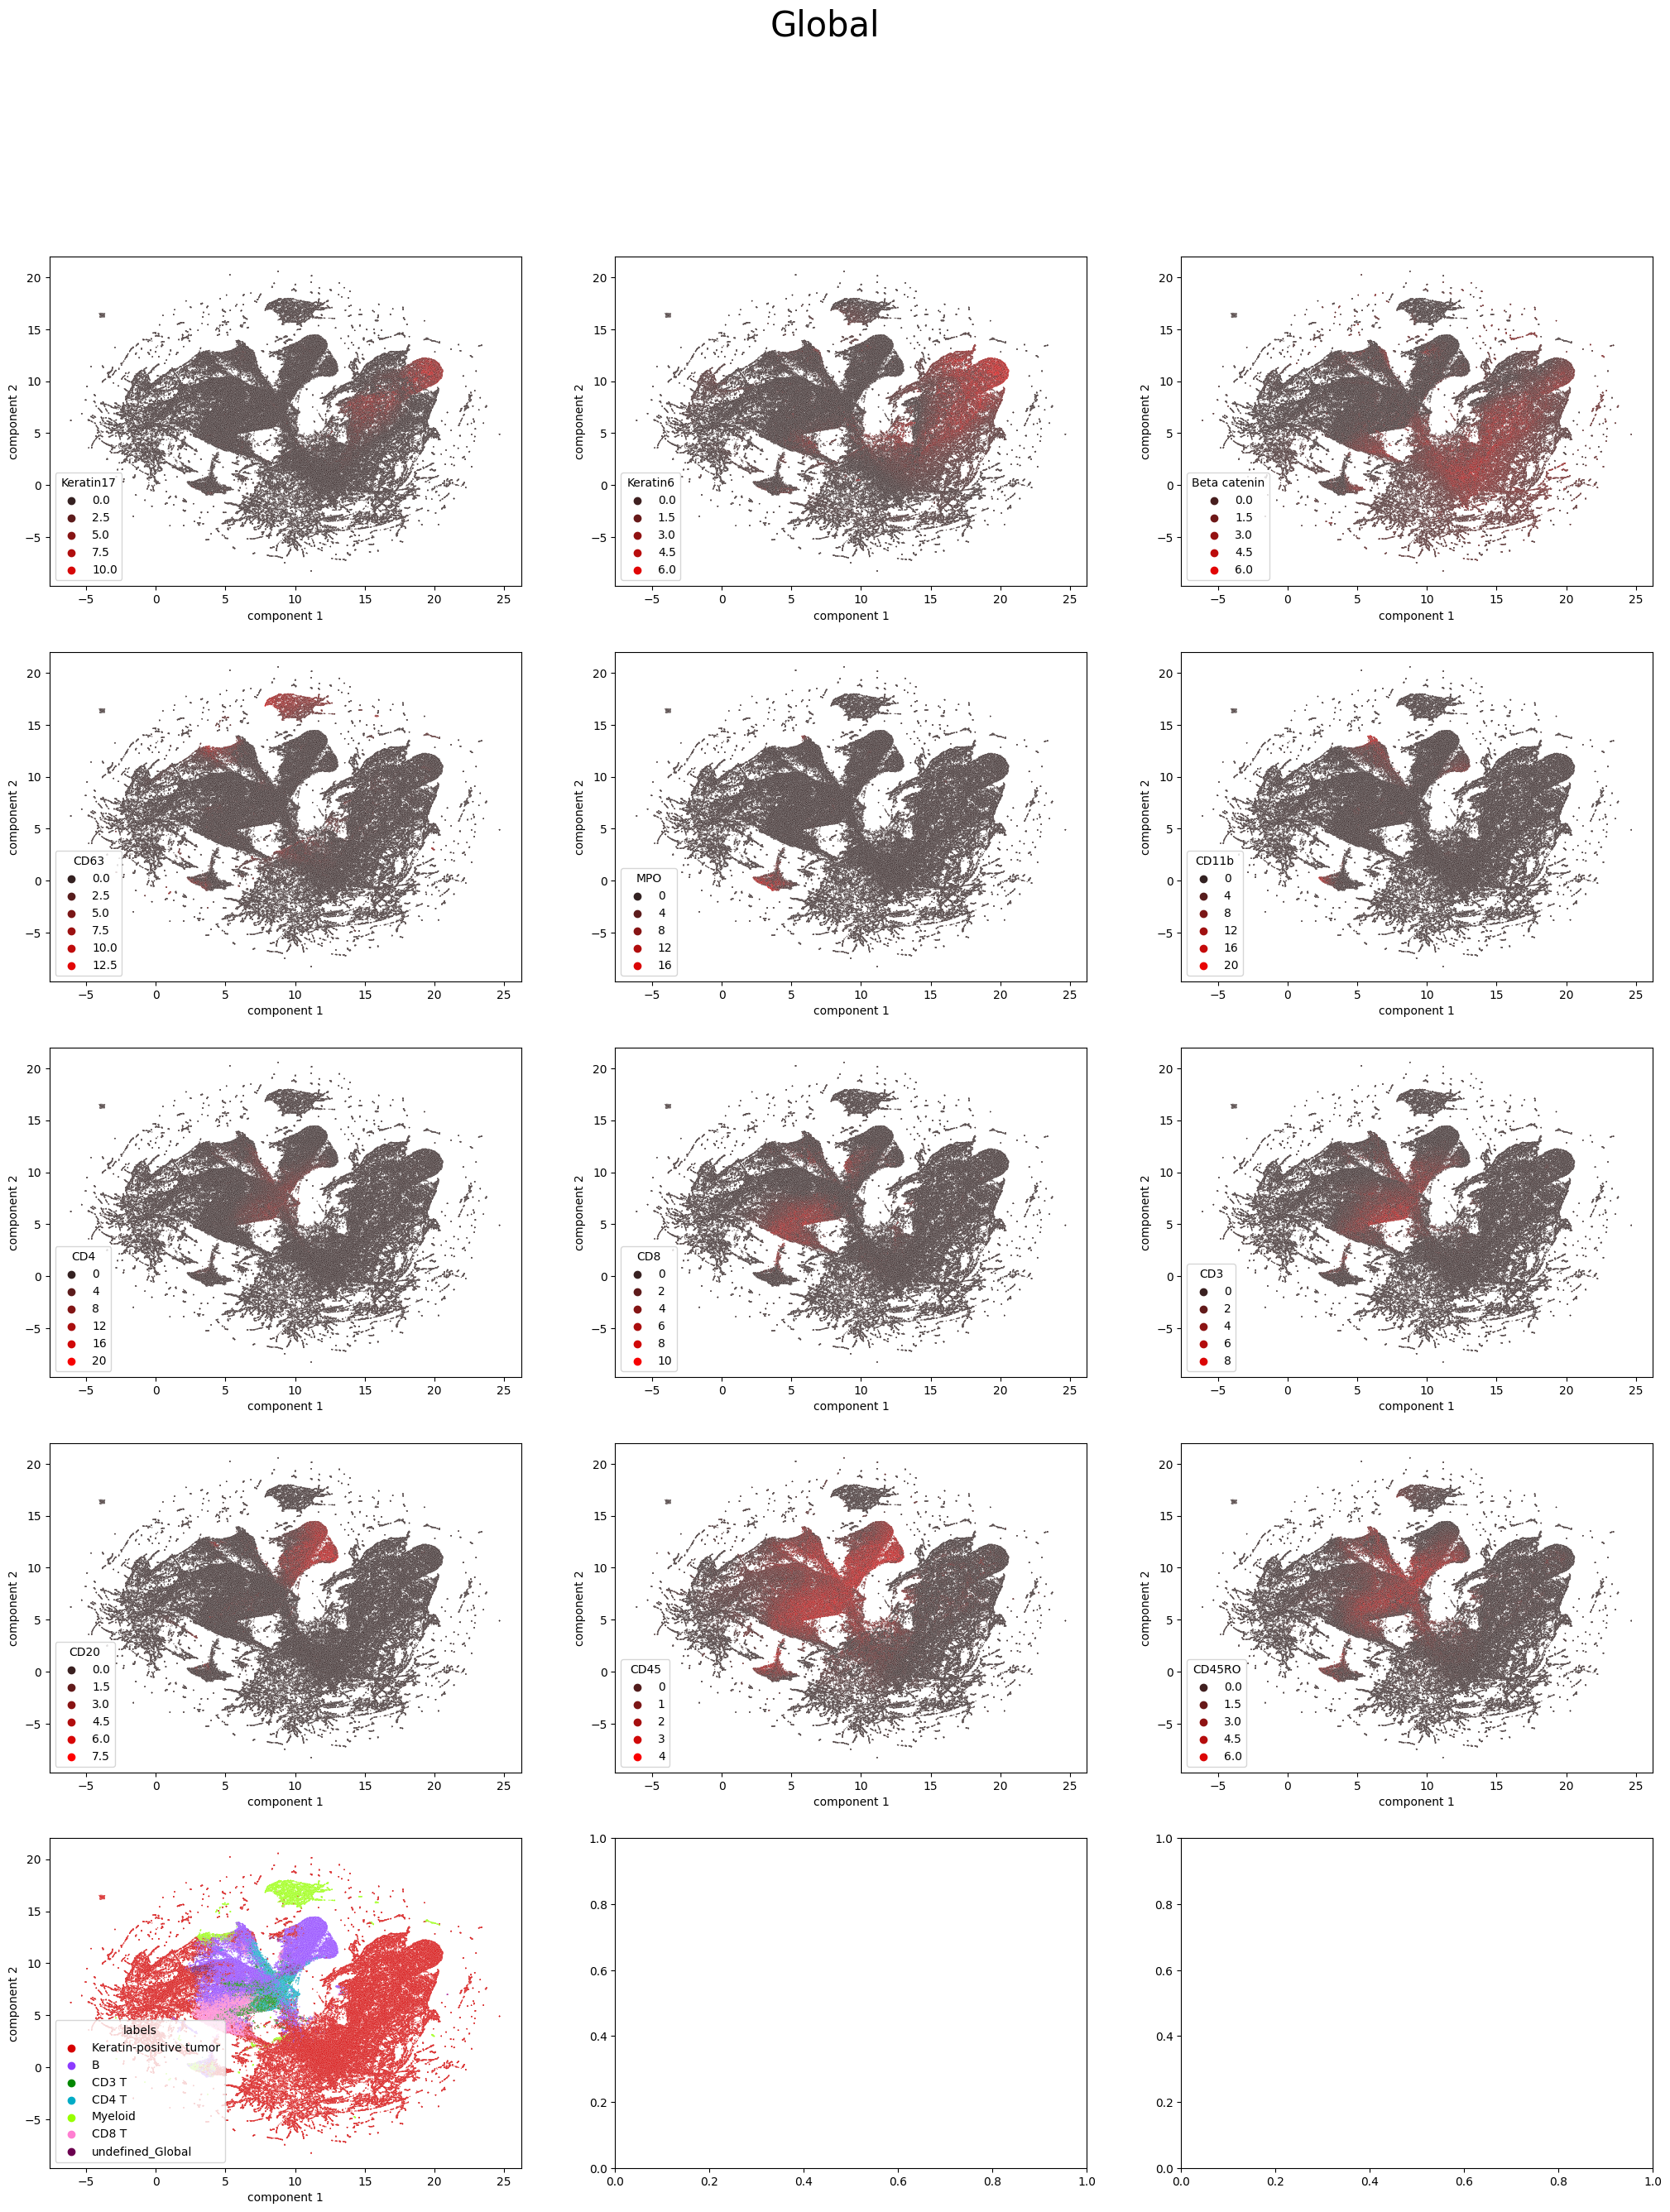

In [9]:
# scale the dataset into (0,1) before UMAP
#scaler = MinMaxScaler() 
#arr_scaled = scaler.fit_transform(sample_data)
#sample_data_scaled = pd.DataFrame(arr_scaled, columns=sample_data.columns,index=sample_data.index)

umap_vis(sample_data, labels, markers=logic["Global"].index.values.tolist(), save=False, fname=None,  level="Global", title=None, init='spectral',
             random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation', palette_markers='mycolormap',
             palette_cell='tab10', dpi='figure')